### Quadruped PID tracking of random trajectories

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from mujoco_parser import MuJoCoParserClass
from pid import PID_ControllerClass
from grp import GaussianRandomPathClass,kernel_se,kernel_levse
from snapbot_util import get_snapbot_q,wait_until_snapbot_on_ground
from util import soft_squash_multidim,get_colors
print ("Done.")

Done.


### Instantiate

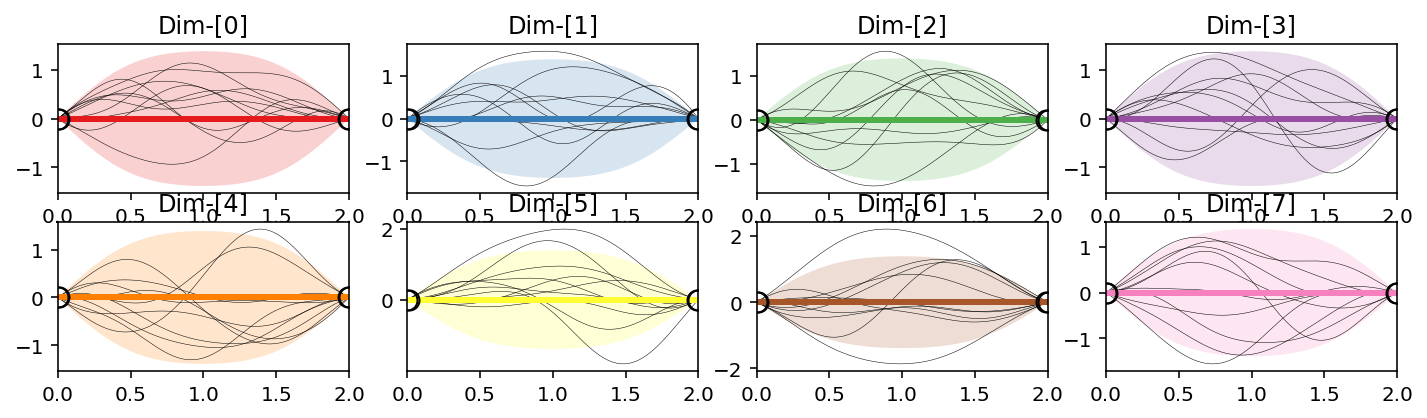

In [2]:
env = MuJoCoParserClass(name='Snapbot',rel_path='../asset/snapbot/robot_4_1245.xml',VERBOSE=False)
PID = PID_ControllerClass(
    name    = 'PID',
    k_p     = 20.0,
    k_i     = 0.1,
    k_d     = 1.0,
    dim     = env.n_torque,
    out_min = env.torque_range[:,0],
    out_max = env.torque_range[:,1])
GRP = GaussianRandomPathClass(name='LGRP',kernel=kernel_levse)
max_sec = 2.0
GRP.set_data(t_anchor    = np.linspace(start=0.0,stop=2.0,num=2).reshape((-1,1)),
             x_anchor    = np.zeros(shape=(2,8)),
             l_anchor    = np.array([[1.0,1.0]]).T,
             t_test      = np.linspace(start=0.0,stop=max_sec,num=int(max_sec*env.HZ)).reshape((-1,1)),
             l_test      = np.ones((int(max_sec*env.HZ),1)),
             hyp_mean    = {'g':0.5,'l':0.5,'w':1e-8},
             hyp_var     = {'g':0.5,'l':0.5,'w':1e-8},
             APPLY_EPSRU = True,
             t_eps       = 0.01)
GRP.plot(n_sample=10,figsize=(12,3),subplot_rc=(2,4),tfs=12)

Creating offscreen glfw


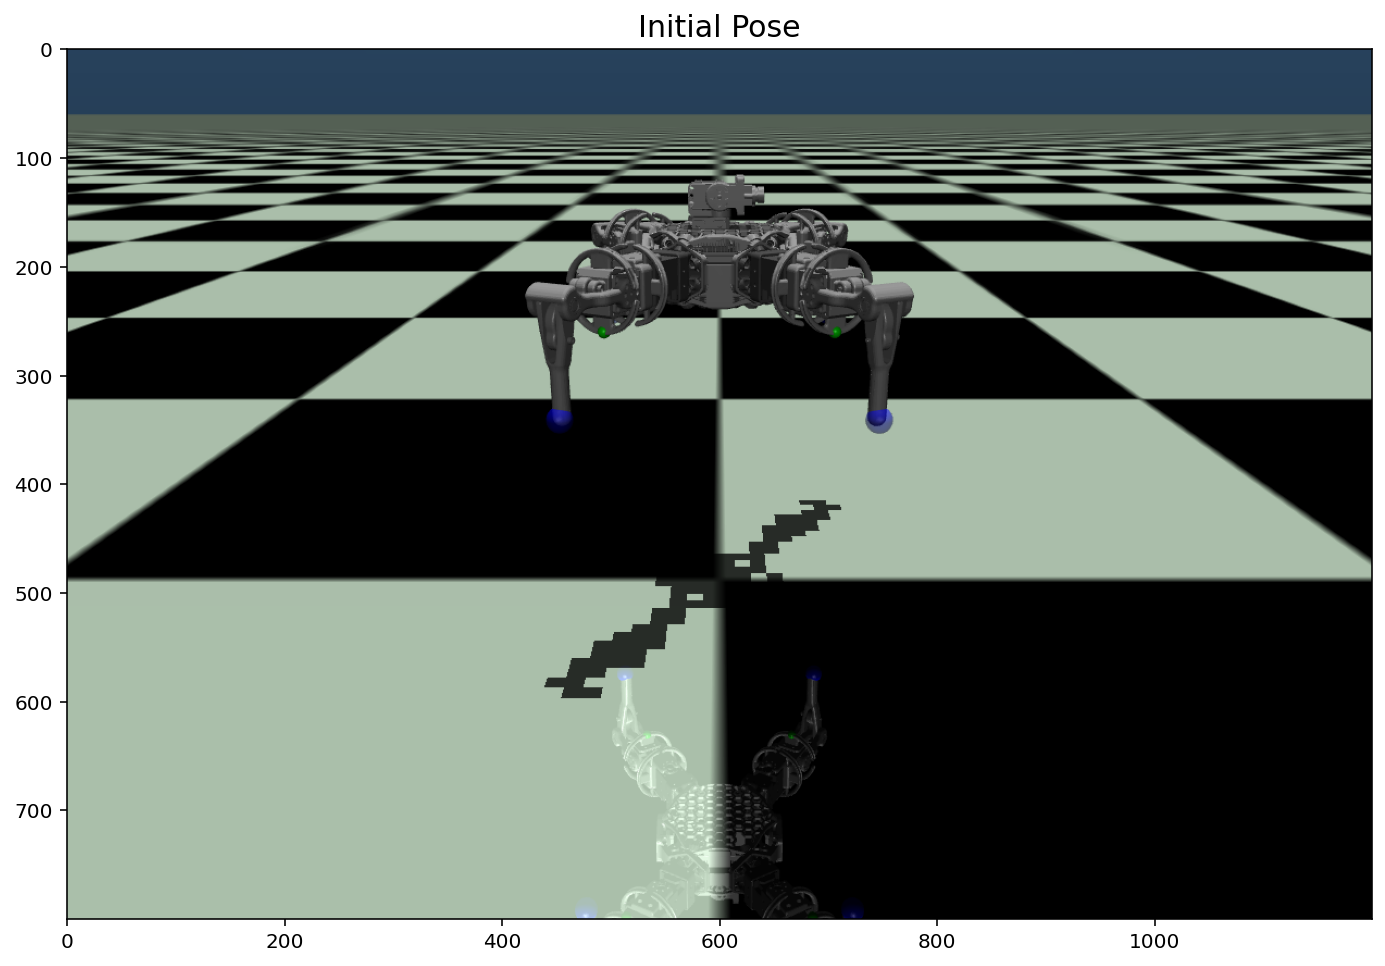

In [3]:
env.plot_scene(figsize=(12,8),render_w=1200,render_h=800,
               cam_distance=1.0,cam_elevation=-20,cam_lookat=[0,0,-0.2],
               title_str='Initial Pose',title_fs=15)

In [4]:
# First, wait until Snapbot reaches ground
env.init_viewer(TERMINATE_GLFW=True,window_width=0.5,window_height=0.5,cam_distance=1.0,
                cam_elevation=-20,cam_lookat=[0,0,-0.2])
env.reset()
PID.reset()
while (env.get_sec_sim()<=2.0):
    q = get_snapbot_q(env)
    PID.update(x_trgt=np.zeros(env.n_torque),t_curr=env.get_sec_sim(),x_curr=q,VERBOSE=False)
    env.step_and_render(torque=PID.out(),TORQUE_TO_REV_JOINT=False,render_speedup=1.0)
    env.print(print_every_sec=1,VERBOSE=1)
print ("Done.")

Creating window glfw
tick:[1/50000], sec_wall:[0.389]sec, sec_sim:[0.004]sec
tick:[251/50000], sec_wall:[0.872]sec, sec_sim:[1.004]sec
Done.


Creating window glfw


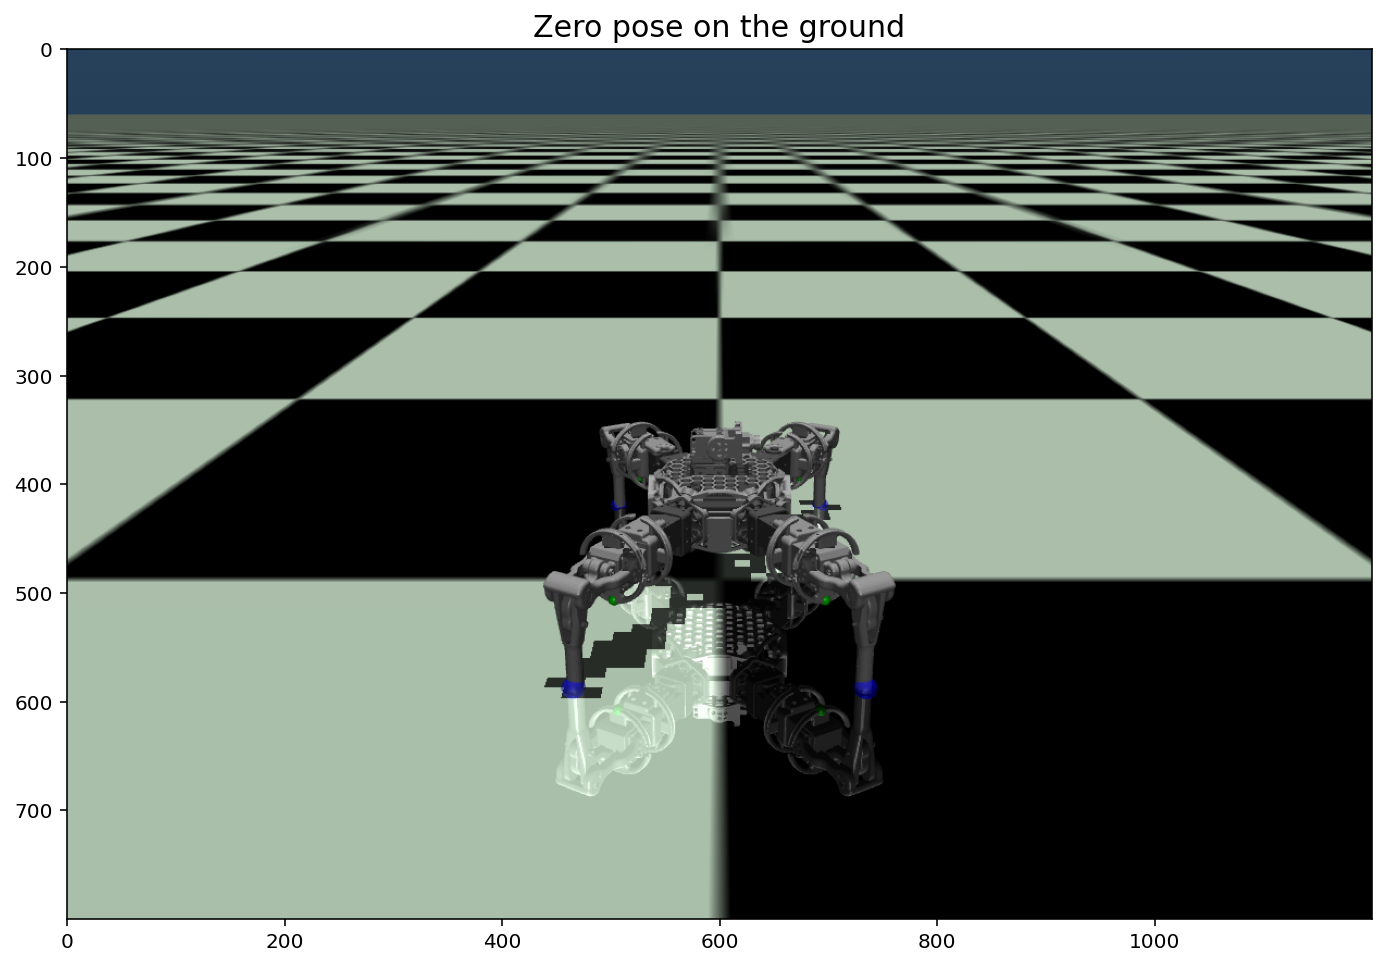

In [5]:
env.init_viewer(TERMINATE_GLFW=True)
env.plot_scene(figsize=(12,8),render_w=1200,render_h=800,
               cam_distance=1.0,cam_elevation=-20,cam_lookat=[0,0,-0.2],
               title_str='Zero pose on the ground',title_fs=15)

### Sample random trajectories from GRP and let Snapbot track the trajectories

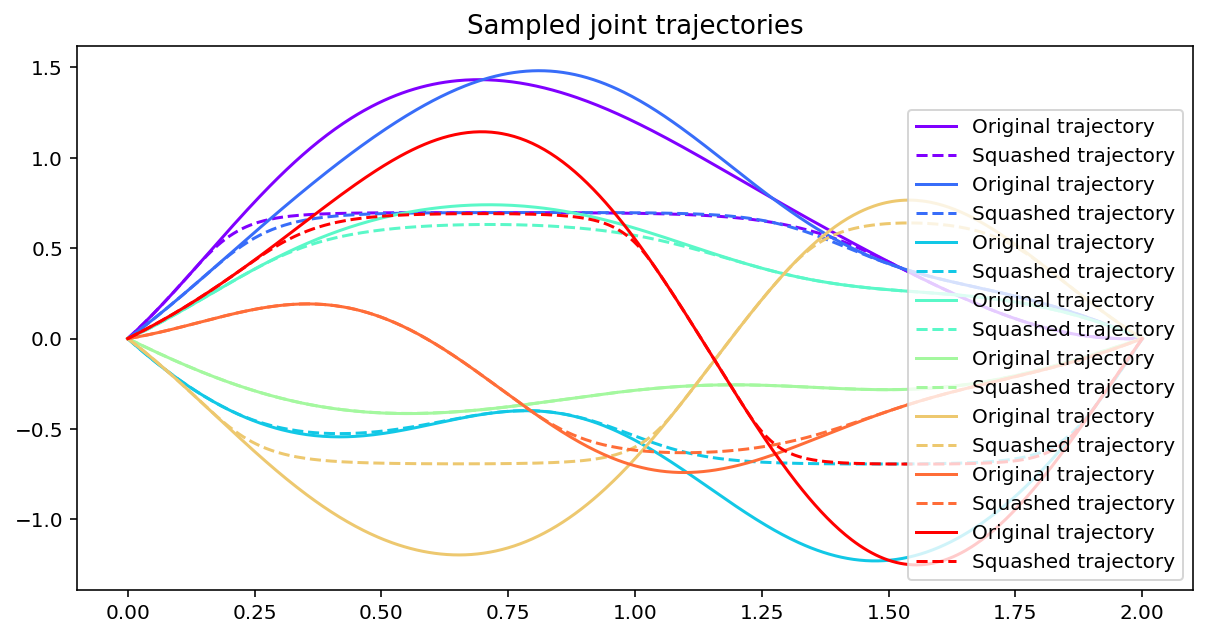

Creating window glfw
tick:[501/50000], sec_wall:[0.444]sec, sec_sim:[2.004]sec
tick:[751/50000], sec_wall:[1.478]sec, sec_sim:[3.004]sec
tick:[1001/50000], sec_wall:[2.469]sec, sec_sim:[4.004]sec
tick:[1251/50000], sec_wall:[3.500]sec, sec_sim:[5.004]sec
tick:[1501/50000], sec_wall:[4.561]sec, sec_sim:[6.004]sec
tick:[1751/50000], sec_wall:[5.595]sec, sec_sim:[7.004]sec
tick:[2001/50000], sec_wall:[6.598]sec, sec_sim:[8.004]sec
tick:[2251/50000], sec_wall:[7.626]sec, sec_sim:[9.004]sec
tick:[2501/50000], sec_wall:[8.691]sec, sec_sim:[10.004]sec
tick:[2751/50000], sec_wall:[9.693]sec, sec_sim:[11.004]sec
Done.


In [6]:
traj_joints,traj_secs = GRP.sample_one_traj(rand_type='Uniform')
traj_joints_squash = soft_squash_multidim(
    x      = traj_joints,
    x_min  = -40*np.pi/180*np.ones(env.n_torque),
    x_max  = +40*np.pi/180*np.ones(env.n_torque),
    margin = 20*np.pi/180)
plt.figure(figsize=(10,5))
colors = get_colors(n=env.n_torque)
for i_idx in range(env.n_torque):
    color = colors[i_idx]
    plt.plot(traj_secs,traj_joints[:,i_idx],'-',color=color,label='Original trajectory')
    plt.plot(traj_secs,traj_joints_squash[:,i_idx],'--',color=color,label='Squashed trajectory')
plt.legend(loc='lower right')
plt.title('Sampled joint trajectories',fontsize=13)
plt.show()
# Wait until snapbot on ground
wait_until_snapbot_on_ground(env,PID)
# Loop
L,n_traj_repeat = len(traj_secs),5
env.init_viewer(TERMINATE_GLFW=True,window_width=0.5,window_height=0.5,cam_distance=1.0,
                cam_elevation=-20,cam_lookat=[0,0,-0.2])
PID.reset()
# Buffers
cnt = 0
sec_list    = np.zeros(shape=(int(L*n_traj_repeat)))
q_trgt_list = np.zeros(shape=(int(L*n_traj_repeat),env.n_torque))
q_curr_list = np.zeros(shape=(int(L*n_traj_repeat),env.n_torque))
torque_list = np.zeros(shape=(int(L*n_traj_repeat),env.n_torque))
for r_idx in range(n_traj_repeat):
    for tick in range(L):
        sec    = cnt*env.dt
        q_trgt = traj_joints_squash[tick,:]
        q_curr = get_snapbot_q(env)
        torque = PID.out()
        PID.update(x_trgt=q_trgt,t_curr=sec,x_curr=q_curr,VERBOSE=False)
        env.step_and_render(torque=torque,TORQUE_TO_REV_JOINT=False,render_speedup=1.0)
        env.print(print_every_sec=1,VERBOSE=1)
        # Append
        sec_list[cnt]      = sec
        q_trgt_list[cnt,:] = q_trgt
        q_curr_list[cnt,:] = q_curr
        torque_list[cnt,:] = torque
        cnt = cnt + 1 # tick
print ("Done.")

In [7]:
env.terminate_viewer() # terminate viewer

### Plot tracking results

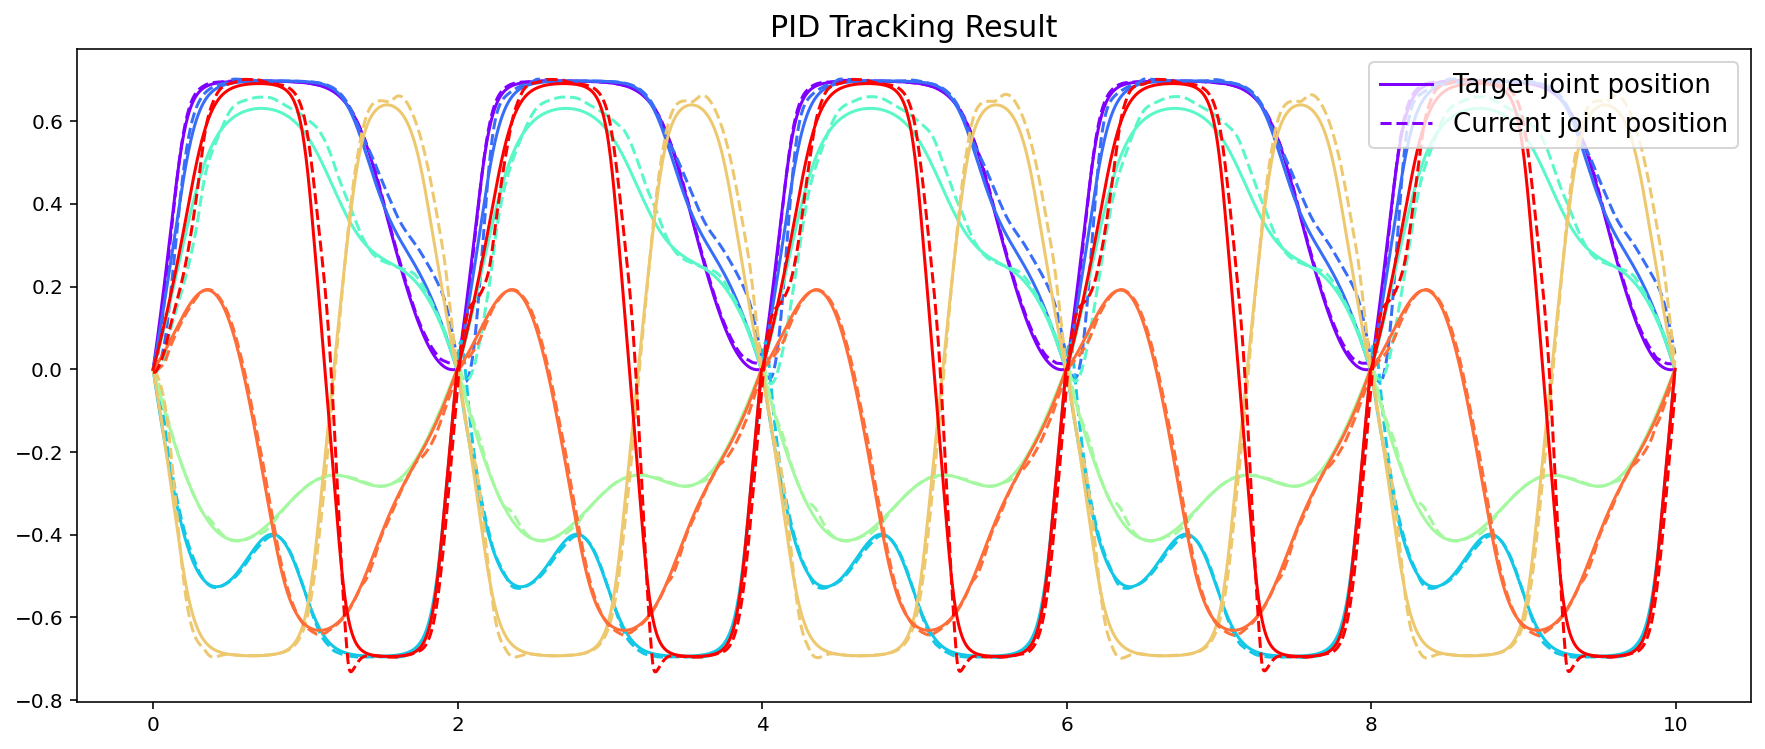

In [8]:
plt.figure(figsize=(15,6))
colors = get_colors(env.n_torque)
for i_idx in range(env.n_torque):
    color = colors[i_idx,:]
    if i_idx == 0: label_trgt,label_curr = 'Target joint position','Current joint position'
    else: label_trgt,label_curr = None,None
    plt.plot(sec_list,q_trgt_list[:,i_idx],'-',color=color,label=label_trgt)
    plt.plot(sec_list,q_curr_list[:,i_idx],'--',color=color,label=label_curr)
plt.legend(fontsize=13,loc='upper right')
plt.title('PID Tracking Result',fontsize=15)
plt.show()